# PLEASE MAKE FOLDER CALLED, ./image/classification

1. Design a 3-layer feedforward neural network consisting of a hidden-layer of 10 neurons having logistic activation function and an output softmax layer. Assume a learning rate 𝛼 = 0.01 and decay parameter 𝛽 = 10−6. Use appropriate scaling of input features

In [36]:
import numpy as np
import theano
import theano.tensor as T
from common.time_executor import get_execution_time

# by specifying [10] as the hidden_layer_neuron implies using 1 hidden layer with 10 neurons
# respectively by specifying [100, 100] -> 2 hidden layers each layer 100 neurons


class SoftmaxNeuralNetwork:

    def __init__(self, train_x, train_y, num_features=6, list_of_neuron_on_hidden_layer=list([10]), decay=1e-6,
                 verbose=True):

        self.train_x = train_x
        self.train_y = train_y
        self.verbose = verbose

        self.train_cost = []
        self.train_prediction = []
        self.train_exec_time = []

        self.test_prediction = []

        weights = []
        biases = []

        # first layer which connect to the input layer
        weights.append(
            self.init_weight(len(train_x[0]), list_of_neuron_on_hidden_layer[0]) )
        biases.append(
            self.init_bias(list_of_neuron_on_hidden_layer[0]))

        previous_layer = list_of_neuron_on_hidden_layer[0]

        for layer in range(1, len(list_of_neuron_on_hidden_layer)):
            weights.append(
                self.init_weight(previous_layer, list_of_neuron_on_hidden_layer[layer]))

            biases.append(
                self.init_bias(list_of_neuron_on_hidden_layer[layer]))

        # for output layer
        weights.append(
            self.init_weight(previous_layer, num_features)
        )

        biases.append(
            self.init_bias(num_features)
        )

        # construct neural network

        layers = []

        x_input = T.matrix('X')
        y_output = T.matrix('Y')

        prev_input = x_input

        for i in range(len(weights)-1):
            calculation = T.nnet.sigmoid(T.dot(prev_input, weights[i]) + biases[i])
            layers.append(calculation)
            prev_input = calculation

        # last output layer, use softmax function
        calculation = T.nnet.softmax(T.dot(prev_input, weights[len(weights)-1]) +
                                     biases[len(biases) - 1])
        layers.append(calculation)

        y_prediction = T.argmax(calculation, axis=1)

        sum_sqr_weights = T.sqr(weights[0])

        for i in range(1, len(weights)):
            sum_sqr_weights += T.sum(T.sqr(weights[i]))

        cost = T.mean(T.nnet.categorical_crossentropy(calculation, y_output)) + decay*T.sum(sum_sqr_weights)
        params = list(weights+biases)
        updates = self.sgd(cost=cost, params=params)

        self.computation = theano.function(
            inputs=[x_input, y_output],
            updates=updates,
            outputs=cost
        )

        self.prediction = theano.function(
            inputs=[x_input],
            outputs=y_prediction
        )

        return

    def init_bias(self, n):
        return theano.shared(np.zeros(n), theano.config.floatX)

    def init_weight(self, n_in, n_out, is_logistic_function=False):

        weight = np.random.uniform(
            size=(n_in, n_out),
            low=-np.sqrt(6. / (n_in + n_out)),
            high=np.sqrt(6. / (n_in + n_out)),
        )

        if is_logistic_function:
            weight = weight*4

        return theano.shared(weight, theano.config.floatX)

    def sgd(self, cost, params, lr=0.01):

        # return list of gradients
        grads = T.grad(cost=cost, wrt=params)

        updates = []
        for p, g in zip(params, grads):
            updates.append([p, p - g * lr])
        return updates

    def start_train(self, test_x, test_y, epochs=1000, batch_size=100):

        for i in range(epochs):

            prediction_batch = []

            cost, exec_time = get_execution_time(self.start_one_iter_func, batch_size, prediction_batch)

            # predictions of train data
            prediction = np.mean(prediction_batch)

            self.train_cost.append(cost)
            self.train_prediction.append(prediction)
            self.train_exec_time.append(exec_time)

            print_verbose = (i % 5*batch_size == 0 or i == epochs-1) and self.verbose

            self.start_test(test_x=test_x, test_y=test_y, print_verbose=print_verbose)

            if print_verbose:

                print ('epoch: %d, train cost: %s, train predictions: %s \n' % (i, cost, prediction))
                print('------------------------------------\n')

    def start_one_iter_func(self, batch_size, prediction_batch):

        cost = 0

        for cnt in range(0, len(self.train_x), batch_size):

            end = cnt + batch_size

            if end > len(self.train_x):
                end = len(self.train_x)

            train_x_batch = self.train_x[cnt:end]
            train_y_batch = self.train_y[cnt:end]

            cost += self.computation(train_x_batch, train_y_batch)
            prediction = self.prediction(self.train_x)
            predict_in_percentage = np.mean(np.argmax(self.train_y, axis=1) == prediction)
            prediction_batch.append(predict_in_percentage)

        return cost

    def start_test(self, test_x, test_y, print_verbose):

        prediction = self.prediction(test_x)

        predict_in_percentage = np.mean(np.argmax(test_y, axis=1) == prediction)
        self.test_prediction.append(predict_in_percentage)

        if print_verbose:
            print ('test predictions: %s \n' % predict_in_percentage)

    def get_train_result(self):

        return self.train_cost, self.train_prediction, np.sum(self.train_exec_time)

    def get_test_result(self):

        return self.test_prediction


Above code is the class to instanstiate the softmax neural network, Below is the implementation of data preprocessing

In [12]:
import pandas as pd
import numpy as np


class DataCollector:

    def __init__(self):
        self.df_train = pd.read_csv("./data/sat_train.txt", delimiter=' ')
        self.df_test = pd.read_csv("./data/sat_test.txt", delimiter=' ')

        # change the index
        self.df_train.columns = range(self.df_train.shape[1])
        self.df_test.columns = range(self.df_test.shape[1])

        self.x_train = self.df_train[range(36)]
        self.y_train = self.df_train[36]

        self.x_test = self.df_test[range(36)]
        self.y_test = self.df_test[36]

        return

    def get_train_data(self):

        return self.x_train, self.one_hot_encoding_data(self.y_train)

    def get_test_data(self):

        return self.x_test, self.one_hot_encoding_data(self.y_test)

    def one_hot_encoding_data(self, df, limit_number=6):

        # in this case data 6 is missing so, 7 we assume to be 6
        df[df == 7] = 6
        df_return = np.zeros((df.shape[0], limit_number))
        df_return[np.arange(df.shape[0]), df - 1] = 1
        return df_return

As there is a need to calculate the execution time of gicen function, hence, helper function to calculate the execution time is developed

In [13]:
import timeit


def get_execution_time(func, *args):
    start_time = timeit.default_timer()
    result = func(*args)
    elapsed = timeit.default_timer() - start_time
    return result, elapsed

Start training the simple multi layer softmax neural network

In [8]:
data_collector = DataCollector()
train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

number_data = train_x.shape[0]

softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, list_of_neuron_on_hidden_layer=[10])
softmax_nn.start_train(batch_size=number_data, test_x=test_x, test_y=test_y)

epoch: 0, train cost: 1.80356396454, train predictions: 0.105773567885 

test cost: 1.7874675121, test predictions: 0.11855927964 

------------------------------------

epoch: 5, train cost: 1.77735232521, train predictions: 0.10599909788 

test cost: 1.77412774973, test predictions: 0.11855927964 

------------------------------------

epoch: 10, train cost: 1.76535487108, train predictions: 0.10599909788 

test cost: 1.76321592906, test predictions: 0.11855927964 

------------------------------------

epoch: 15, train cost: 1.7541081678, train predictions: 0.10599909788 

test cost: 1.75300565699, test predictions: 0.11855927964 

------------------------------------

epoch: 20, train cost: 1.74349599061, train predictions: 0.10599909788 

test cost: 1.74338994866, test predictions: 0.11855927964 

------------------------------------

epoch: 25, train cost: 1.73346375557, train predictions: 0.10599909788 

test cost: 1.73431427695, test predictions: 0.11855927964 

---------------

epoch: 270, train cost: 1.46732087975, train predictions: 0.461885430762 

test cost: 1.48434153535, test predictions: 0.438219109555 

------------------------------------

epoch: 275, train cost: 1.46382641513, train predictions: 0.461659900767 

test cost: 1.48102739352, test predictions: 0.437218609305 

------------------------------------

epoch: 280, train cost: 1.46037410863, train predictions: 0.462336490753 

test cost: 1.47775815103, test predictions: 0.437218609305 

------------------------------------

epoch: 285, train cost: 1.45696156795, train predictions: 0.46098331078 

test cost: 1.4745339291, test predictions: 0.437218609305 

------------------------------------

epoch: 290, train cost: 1.45358702716, train predictions: 0.461659900767 

test cost: 1.47135487683, test predictions: 0.437218609305 

------------------------------------

epoch: 295, train cost: 1.45024938988, train predictions: 0.461659900767 

test cost: 1.46822063666, test predictions: 0.43721860930

epoch: 540, train cost: 1.32346116658, train predictions: 0.465944970681 

test cost: 1.34770117479, test predictions: 0.456728364182 

------------------------------------

epoch: 545, train cost: 1.32138235477, train predictions: 0.465944970681 

test cost: 1.34566273239, test predictions: 0.456728364182 

------------------------------------

epoch: 550, train cost: 1.31931651481, train predictions: 0.465944970681 

test cost: 1.34363645558, test predictions: 0.456728364182 

------------------------------------

epoch: 555, train cost: 1.31726349631, train predictions: 0.465944970681 

test cost: 1.34162228002, test predictions: 0.456728364182 

------------------------------------

epoch: 560, train cost: 1.31522311316, train predictions: 0.465719440686 

test cost: 1.33962012522, test predictions: 0.456728364182 

------------------------------------

epoch: 565, train cost: 1.3131951439, train predictions: 0.465719440686 

test cost: 1.33762988762, test predictions: 0.4562281140

epoch: 810, train cost: 1.22615042477, train predictions: 0.567884528642 

test cost: 1.25135290334, test predictions: 0.560780390195 

------------------------------------

epoch: 815, train cost: 1.22460931209, train predictions: 0.571944068561 

test cost: 1.24980973179, test predictions: 0.566283141571 

------------------------------------

epoch: 820, train cost: 1.22307640159, train predictions: 0.57352277853 

test cost: 1.24827393864, test predictions: 0.566283141571 

------------------------------------

epoch: 825, train cost: 1.2215515802, train predictions: 0.573973838521 

test cost: 1.24674535937, test predictions: 0.566283141571 

------------------------------------

epoch: 830, train cost: 1.22003473838, train predictions: 0.573973838521 

test cost: 1.24522383092, test predictions: 0.566783391696 

------------------------------------

epoch: 835, train cost: 1.21852576856, train predictions: 0.573748308525 

test cost: 1.24370919292, test predictions: 0.56778389194

2. Find the optimal batch size for mini-batch gradient descent while training the neural network by evaluating the performances for different batch sizes. Set this as the batch size for the rest of the experiments

a) Plot the training error and test accuracy against number of epochs for the 3-layer
network for each batch size. Limit search space to:{4,8,16,32,64}. 

As the helper class to do plotting stuff, we create another class to do such task.

In [14]:
import matplotlib.pyplot as plt


class DataVisualization:

    def __init__(self):
        return

    def show_plot(self, list_x_point, list_y_point, x_label, y_label, title, figure_name):
        plt.figure()
        plt.plot(list_x_point, list_y_point)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.savefig(figure_name)
        plt.show()

a.Plot the training error and test accuracy against number of epochs for the 3-layer
network for each batch size. Limit search space to:{4,8,16,32,64}. 

train with batch size 4, 8, 16, 32 ,64

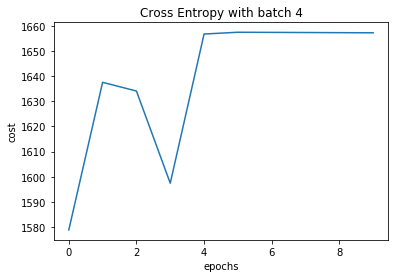

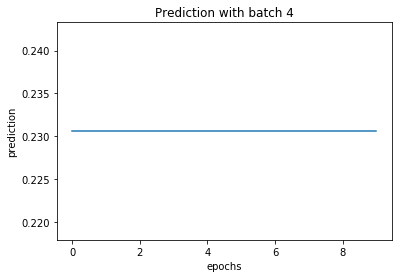

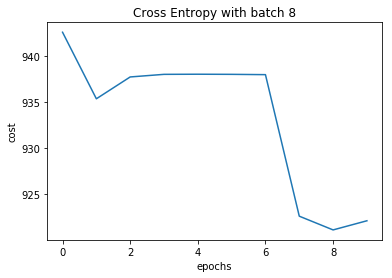

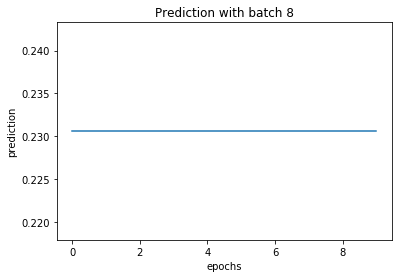

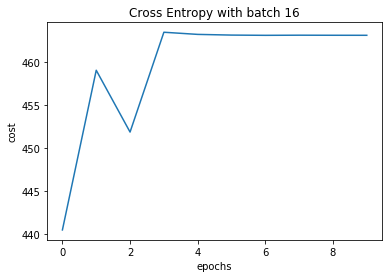

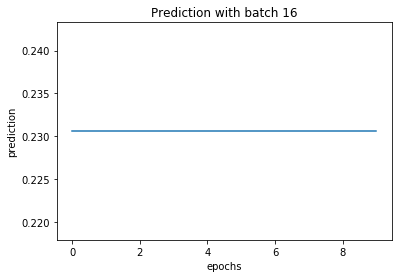

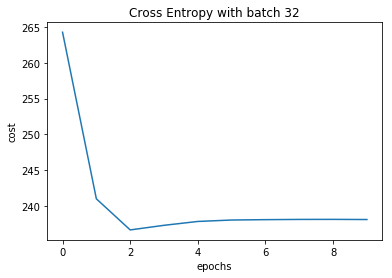

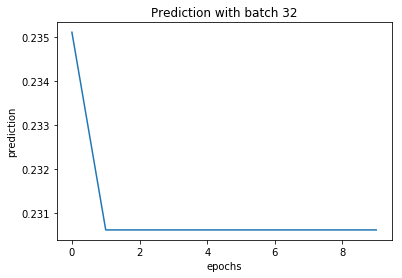

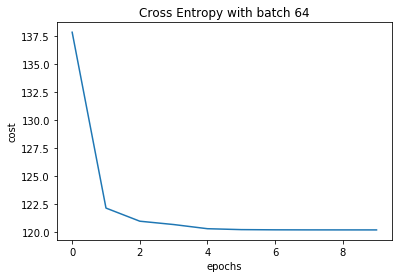

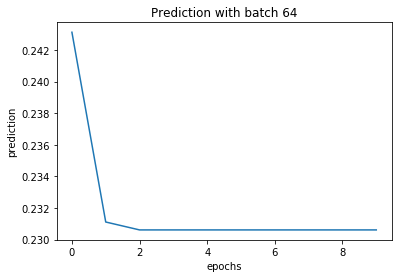

In [33]:
data_collector = DataCollector()
train_x, train_y = data_collector.get_train_data()
test_x, test_y = data_collector.get_test_data()

# number_data = train_x.shape[0]
list_batch = [4, 8, 16, 32, 64]
list_execution_time = []

number_epoch = 10

# visualize
data_visualization = DataVisualization()

for batch in list_batch:
    
    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[10], verbose=False)
    softmax_nn.start_train(batch_size=batch, test_x=test_x, test_y=test_y, epochs=number_epoch)

    cost_train, prediction_train, exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result()

    %matplotlib inline
    
    data_visualization.show_plot(
        list_x_point=range(number_epoch), list_y_point=cost_train,
        x_label="epochs", y_label="cost", title="Cross Entropy with batch "+str(batch), figure_name="./image/classification/2/"+str(batch)+"_cross_entropy.png"
    )
    
    data_visualization.show_plot(
        list_x_point=range(number_epoch), list_y_point=prediction_test,
        x_label="epochs", y_label="prediction", title="Prediction with batch "+str(batch), figure_name="./image/classification/2/"+str(batch)+"_prediction.png"
    )
    
    list_execution_time.append(exec_time)

b) Plot the time taken to update parameters of the network for different batch sizes.

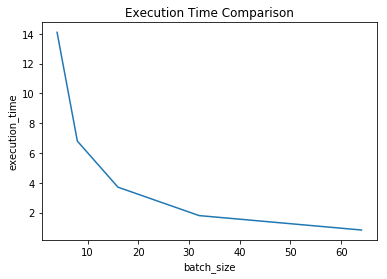

In [16]:
%matplotlib inline

data_visualization.show_plot(
    list_x_point=list_batch, list_y_point=list_execution_time,
    x_label="batch_size", y_label="execution_time", title="Execution Time Comparison", figure_name="./image/classification/2/execution_time_comparison.png"
)

c) State the rationale for selecting the optimal batch size.

The best batch size depends on the RAM used, it needs to maximize the usage of the RAM so that the execution time can be reduced as well.

3. Find the optimal number of hidden neurons for the 3-layer network designed in part (2). Set this number of neurons in hidden layer for the rest of the experiments.

a) Plot the training error and test accuracy against number of epochs for the 3-layer
network at hidden-layer neurons. Limit the search space to the set:
{5,10,15,20,25}.

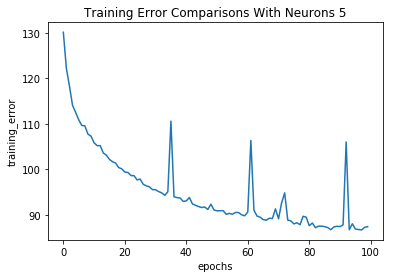

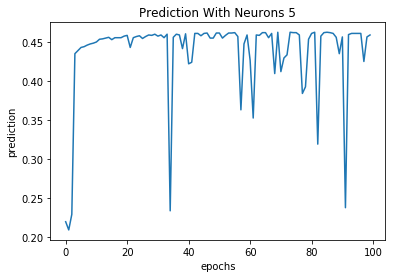

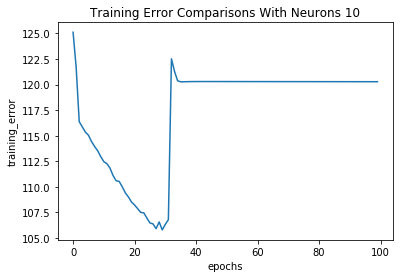

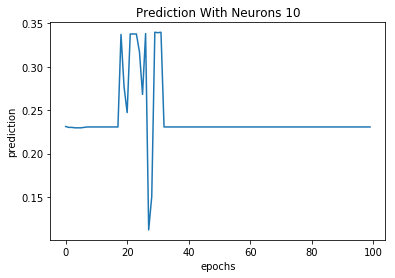

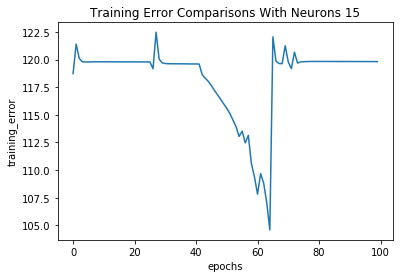

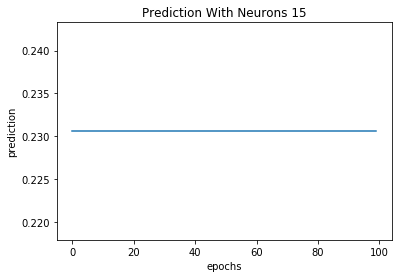

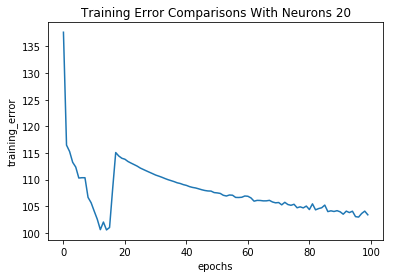

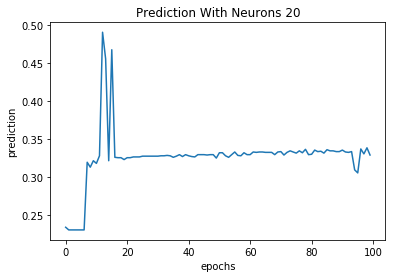

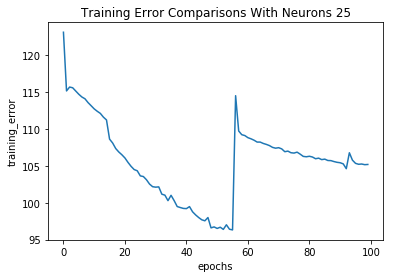

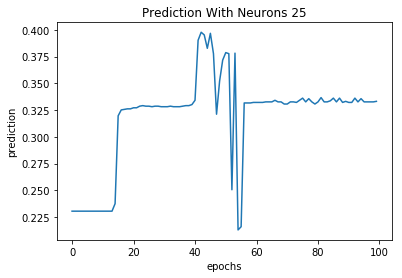

In [34]:
list_neurons = [5, 10, 15, 20, 25]
batch_size = 64
epochs = 100

list_training_error, list_test_prediction, list_execution_time = [], [], []

for neurons in list_neurons:

    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[neurons], verbose=False)
    softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)
    
    cost_train, prediction_train, exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result()
    
    list_training_error.append(cost_train)
    list_test_prediction.append(prediction_test)
    list_execution_time.append(exec_time)

    %matplotlib inline
    
    data_visualization.show_plot(
        list_x_point=range(epochs), list_y_point=cost_train,
        x_label="epochs", y_label="training_error", title="Training Error Comparisons With Neurons " + str(neurons),
        figure_name="./image/classification/3/"+str(neurons)+"_training_error_comparison.png"
    )
    data_visualization.show_plot(
        list_x_point=range(epochs), list_y_point=prediction_test,
        x_label="epochs", y_label="prediction", title="Prediction With Neurons " + str(neurons),
        figure_name="./image/classification/3/"+str(neurons)+"_prediction_comparison.png"
    )

b) Plot the time to update parameters of the network for different number of hiddenlayer
neurons

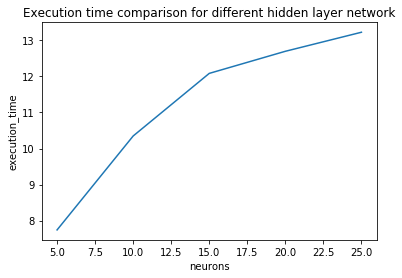

In [25]:
%matplotlib inline

data_visualization.show_plot(
    list_x_point=list_neurons, list_y_point=list_execution_time,
    x_label="neurons", y_label="execution_time", title="Execution time comparison for different hidden layer network",
    figure_name="./image/classification/3/hidden_layer_xec_time_comparison.png"
)

c) State the rationale for selecting the optimal number of hidden neurons

The increament of neurons means the increament of weight that need to be trained as well. hence, to get a converge cost result, we need to train the neural network with more epochs.

4. Find optimal decay parameter for the 3-layer network designed in part (3)

a) Plot the training error against number of epochs for the 3-layer network for
different values of decay parameter in search space{0, 10−3
,10−6
, 10−9
,10−12}.
b) Plot the test accuracy against the different values of decay parameter.

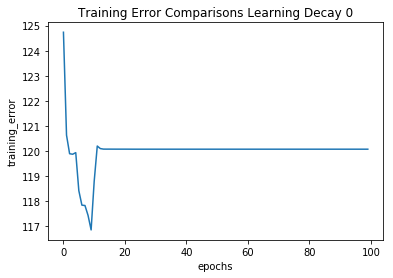

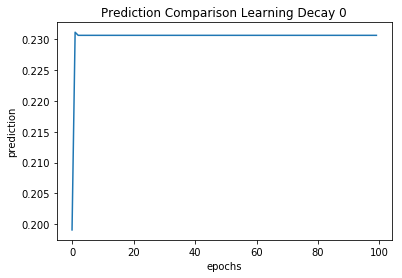

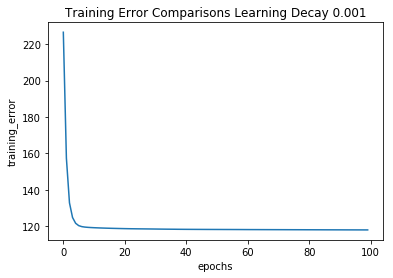

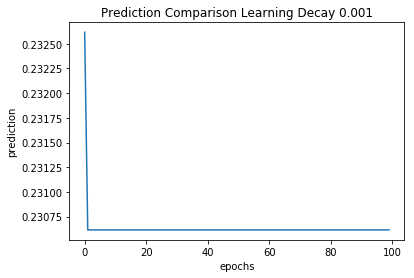

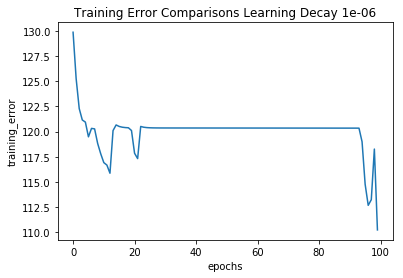

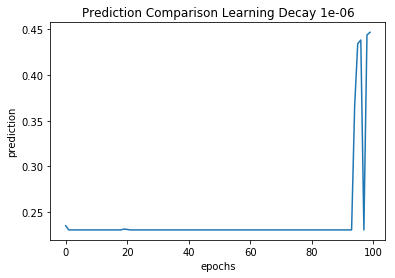

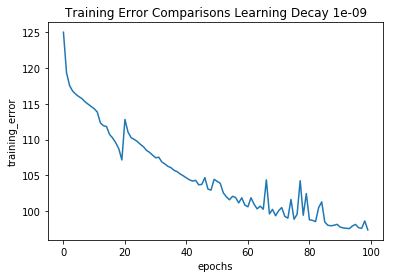

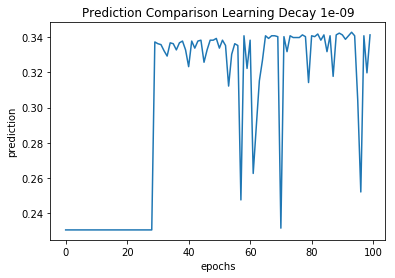

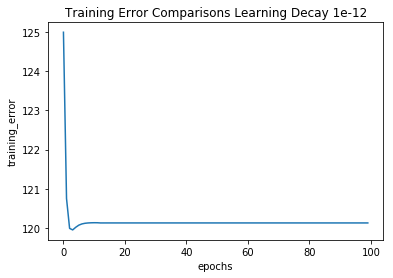

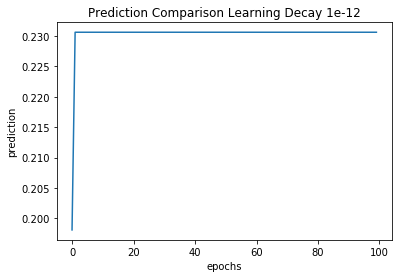

In [32]:
learning_decays = [0, 1e-3, 1e-6, 1e-9, 1e-12]
batch_size = 64
epochs = 100

list_training_error, list_test_prediction = [], []

for decay in learning_decays:

    softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, 
                                      list_of_neuron_on_hidden_layer=[10], verbose=False, decay=decay)
    softmax_nn.start_train(batch_size=batch_size, test_x=test_x, test_y=test_y, epochs=epochs)
    
    cost_train, prediction_train, exec_time = softmax_nn.get_train_result()
    prediction_test = softmax_nn.get_test_result()
    
    list_training_error.append(cost_train)
    list_test_prediction.append(prediction_test)

    %matplotlib inline
    
    data_visualization.show_plot(
        list_x_point=range(epochs), list_y_point=cost_train,
        x_label="epochs", y_label="training_error", title="Training Error Comparisons Learning Decay " + str(decay),
        figure_name="./image/classification/4/"+str(neurons)+"_training_error_learning_decays_comparison.png"
    )
    data_visualization.show_plot(
        list_x_point=range(epochs), list_y_point=prediction_test,
        x_label="epochs", y_label="prediction", title="Prediction Comparison Learning Decay " + str(decay),
        figure_name="./image/classification/4/"+str(decay)+"_prediction_learning_decay_comparison.png"
    )

c) State the rationale for selecting the optimal decay parameter. 

Learing decay causing the cost function to be adjusted based on the weight, which means more fluctuation happened, such that the best learning decay is the one which give us the less fluctuate result.

5. After you’re done with the 3-layer network, design a 4-layer network with two hiddenlayers,each consisting of 10 neurons with logistic activation functions, batch size of 32 and decay parameter 10-6.

a) Plot the train and test accuracy of the 4-layer network.
b) Compare and comment on the performances on 3-layer and 4-layer networks.

test predictions: 0.198099049525 

epoch: 0, train cost: 248.65375877, train predictions: 0.216966345733 

------------------------------------

test predictions: 0.230615307654 

epoch: 5, train cost: 227.872900007, train predictions: 0.326885446987 

------------------------------------

test predictions: 0.230615307654 

epoch: 10, train cost: 215.35259818, train predictions: 0.427520500514 

------------------------------------

test predictions: 0.455227613807 

epoch: 15, train cost: 211.263901068, train predictions: 0.338952113005 

------------------------------------

test predictions: 0.451725862931 

epoch: 20, train cost: 203.010036065, train predictions: 0.408999458079 

------------------------------------

test predictions: 0.230615307654 

epoch: 25, train cost: 196.189374244, train predictions: 0.3753727735 

------------------------------------

test predictions: 0.230615307654 

epoch: 30, train cost: 224.744440952, train predictions: 0.305406554324 

---------------

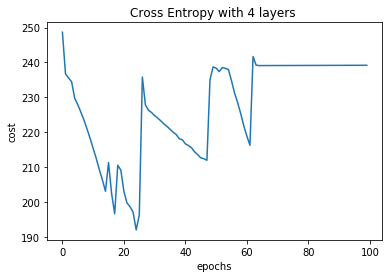

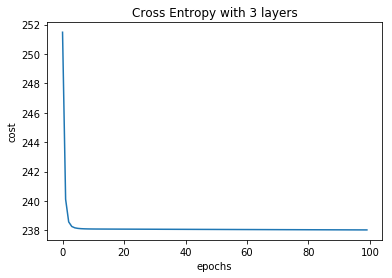

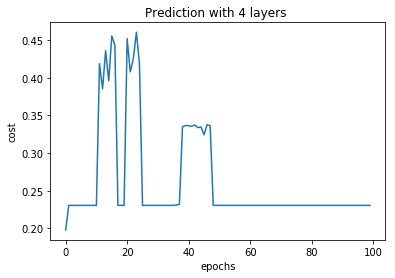

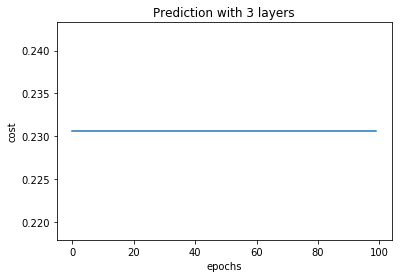

In [39]:
number_data=32
epochs=100

softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, list_of_neuron_on_hidden_layer=[10, 10])
softmax_nn.start_train(batch_size=number_data, test_x=test_x, test_y=test_y, epochs=epochs)

cost_train_4_layer, _, _ = softmax_nn.get_train_result()
prediction_test_4_layer = softmax_nn.get_test_result()


softmax_nn = SoftmaxNeuralNetwork(train_x=train_x.as_matrix(), train_y=train_y, list_of_neuron_on_hidden_layer=[10])
softmax_nn.start_train(batch_size=number_data, test_x=test_x, test_y=test_y, epochs=epochs)

cost_train_3_layer, _, _ = softmax_nn.get_train_result()
prediction_test_3_layer = softmax_nn.get_test_result()


data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=cost_train_4_layer,
    x_label="epochs", y_label="cost", title="Cross Entropy with 4 layers ", figure_name="./image/classification/5/4_layer_cross_entropy.png"
)

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=cost_train_3_layer,
    x_label="epochs", y_label="cost", title="Cross Entropy with 3 layers", figure_name="./image/classification/5/3_layer_cross_entropy.png"
)


data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=prediction_test_4_layer,
    x_label="epochs", y_label="cost", title="Prediction with 4 layers ", figure_name="./image/classification/5/4_layer_prediction.png"
)

data_visualization.show_plot(
    list_x_point=range(epochs), list_y_point=prediction_test_3_layer,
    x_label="epochs", y_label="cost", title="Prediction with 3 layers", figure_name="./image/classification/5/3_layer_prediction.png"
)